In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import namedtuple
from itertools import count
import math
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

In [2]:
env = gym.make('CartPole-v1').unwrapped
plt.ion() # interactive on <-> ioff

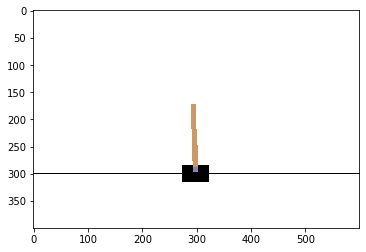

In [3]:
env.reset()
screen = env.render(mode='rgb_array')
plt.imshow(screen)

In [4]:
env.close()

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
preprocess = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((400,600)),
                                 transforms.ToTensor()])

In [7]:
def get_screen():
    screen = env.render(mode='rgb_array').transpose((2,0,1))
    screen = np.ascontiguousarray(screen) # vital
    screen = torch.from_numpy(screen)
    return preprocess(screen).unsqueeze(0).cuda()

In [9]:
def plot_durations():
    plt.figure(2)
    plt.clf() # clear figure
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device='cuda:0', dtype=torch.long)

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)), device='cuda:0', dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken in each state.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device='cuda:0')
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [11]:
class DQN(nn.Module):

    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(32, outputs)

    def forward(self, x):
        tmp = self.block1(x)
        tmp = self.block2(tmp)
        tmp = self.block3(tmp)
        tmp = self.pooling(tmp)
        tmp = torch.flatten(tmp,start_dim=1)
        tmp = self.fc(tmp)
        
        return tmp

In [12]:
BATCH_SIZE = 16
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

In [13]:
policy_net = DQN(n_actions).cuda()
target_net = DQN(n_actions).cuda()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (block3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (pooling): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [14]:
optimizer = torch.optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(500)

In [15]:
steps_done = 0
num_episodes = 50
episode_durations = []
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device='cuda:0')

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
#             plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.close()
plt.ioff()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:23<00:00,  1.66s/it]

Complete


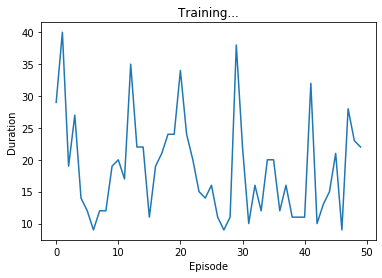

In [16]:
plot_durations()

In [22]:
# 玩 50 次
test_durations = []
for i in range(50):
    env.reset()
    plt.ion()
    policy_net.eval()
    with torch.no_grad():
        for t in count():
            screen = get_screen()
            output = target_net(screen)
            output = output.argmax().item()
            _, reward, done, _ = env.step(output)
            if done : 
                test_durations.append(t)
                break
env.close()
plt.ioff()

In [24]:
np.max(test_durations)

10